In [123]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import contractions

In [124]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Exploration du jeu de données

In [126]:
DATASET_FILE = "/content/drive/MyDrive/IAA2/Sitou/dataset.csv"

In [127]:
dataset_df = pd.read_csv(DATASET_FILE)
dataset_df

,text,stars
0,I've only had food from here once and it wasn'...,1
1,I will never return here again. Ever. I was ...,1
2,I wish my experience was great as others. I di...,1
3,Are the rosemary grapefruit scones supposed to...,1
4,Our takeout order was half wrong. Food was mis...,1
...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5
24996,Stopped here for a bite while wandering around...,5
24997,"A quiet place with excellent food, great music...",5
24998,Super delicious food. Awesome vibe. I suffered...,5


## 1.1 Répartition des avis clients en fonction du nombre d'étoiles

In [128]:
stars_columns = dataset_df.stars
stars_columns

0        1
1        1
2        1
3        1
4        1
        ..
24995    5
24996    5
24997    5
24998    5
24999    5
Name: stars, Length: 25000, dtype: int64

In [129]:
stars_columns.value_counts()

1    5000
2    5000
3    5000
4    5000
5    5000
Name: stars, dtype: int64

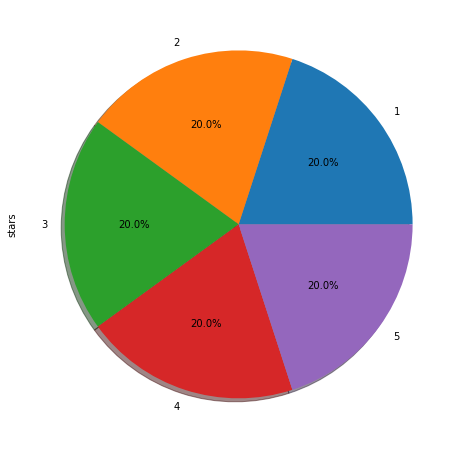

In [130]:
stars_columns.value_counts().plot(kind="pie", figsize=(10, 8), autopct="%1.1f%%", shadow=True)

## 1.2 Distribution de la longueur (nombre de mots) des avis clients

In [131]:
dataset_df["length"] = dataset_df["text"].apply(lambda x: len(x.split()))
dataset_df

,text,stars,length
0,I've only had food from here once and it wasn'...,1,68
1,I will never return here again. Ever. I was ...,1,87
2,I wish my experience was great as others. I di...,1,166
3,Are the rosemary grapefruit scones supposed to...,1,81
4,Our takeout order was half wrong. Food was mis...,1,32
...,...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5,75
24996,Stopped here for a bite while wandering around...,5,55
24997,"A quiet place with excellent food, great music...",5,32
24998,Super delicious food. Awesome vibe. I suffered...,5,41


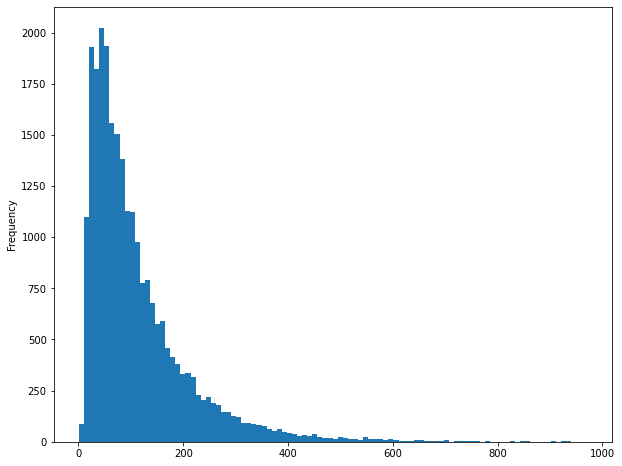

In [132]:
dataset_df.length.plot(kind="hist", bins=100, figsize=(10, 8))

## 1.3 Distribution de la longueur des avis clients en fonction du nombre d'étoiles des avis

Text(0.5, 1.0, "Répartition des longueurs des avis en fonction du nombre d'étoiles")

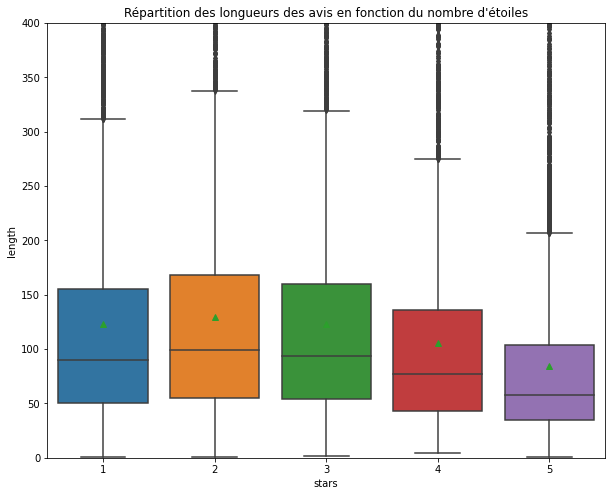

In [133]:
plt.figure(figsize=(10, 8))

ax = sns.boxplot(x=dataset_df.stars ,
            y=dataset_df.length,
            showmeans=True,
            )
ax.set_ylim(0, 400)

ax.set_title("Répartition des longueurs des avis en fonction du nombre d'étoiles")

# 2. Pré-traitement du jeu de données

In [259]:
#On enlève les  contractions dans un premier temps
def remove_contractions(text):
      dataset = contractions.fix(text)
      return dataset


#On tokenize le dataset
from nltk.tokenize import  TreebankWordTokenizer
def tokenisation(text):
  tokenizer= TreebankWordTokenizer()
  tokens=tokenizer.tokenize(text)
  return tokens

 #On crée les stop_words négatifs
def tag_words(tokens):
  neg_stopwords=["never", "nothing", "nowhere", "noone", "none", "not"]
  for i in range(len(tokens)):
      for k in range(len(neg_stopwords)):
        if tokens[i]==neg_stopwords[k] and not tokens[i]==tokens[-1]:
          tokens[i+1]="not_"+ tokens[i+1]

  return tokens 

#On efface les stopwords en anglais ainsi que les mots les plus répétés dans le dataset
#Comptage des mots les plus fréquents dans le dataset
from collections import Counter
def most_commonwords(tokens):
    counter=Counter(tokens)
    most_occur = counter.most_common(2)
    return most_occur 

def my_keys(most_occur):
  most_occur_dict = dict(most_occur)
  cles = most_occur_dict.keys()
  return cles


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
neg_stopwords=["never", "nothing", "nowhere", "noone", "none", "not"]
def stop_words(tokens):
  for i in tokens : 
    if i in stopwords or  neg_stopwords:
        tokens.remove(i)
  return tokens
'''
def stop_words(tokens):
  tokens_cleared = [x for x in tokens if x not in stop_words ]
  return tokens_cleared'''

#Lemmatization

from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('omw-1.4')
#Lemmatisation

def lemmatization(tokens):
  lemmatizer=WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(i) for i in tokens] #for tokens in i]
  return lemmatized_tokens

def postagger(lemmatized_tokens):
  from nltk.tag import StanfordPOSTagger

  st = StanfordPOSTagger()
  postagger = st.tag(lemmatized_tokens)
  return postagger


def normalise(postagger): 

  from nltk.corpus.reader.wordnet import VERB, NOUN, ADJ, ADV
  dict_pos_map = {
      # Look for NN in the POS tag because all nouns begin with NN
      'NN': NOUN,
      # Look for VB in the POS tag because all nouns begin with VB
      'VB':VERB,
      # Look for JJ in the POS tag because all nouns begin with JJ
      'JJ' : ADJ,
      # Look for RB in the POS tag because all nouns begin with RB
      'RB':ADV  
  }
  lemmatizer=WordNetLemmatizer()
  normalized_sequence = []
  for each_seq in postagger:
      normalized_tokens = []
      for tuples in each_seq:
          temp = tuples[0]
          if tuples[1] == "NNP" or tuples[1] == "NNPS":
              continue
          if tuples[1][:2] in dict_pos_map.keys():
              temp = lemmatizer.lemmatize(tuples[0].lower(), 
                                  pos=dict_pos_map[tuples[1][:2]])
          normalized_tokens.append(temp)
      normalized_sequence.append(normalized_tokens)
  return normalized_sequence



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [260]:
#Application des différents prétraitements au dataset

def preprocessing(dataset):
  
  data_contraction=dataset_df["text"].apply(remove_contractions)
  data_tokenizer=data_contraction.apply(tokenisation)
  data_neg=data_tokenizer.apply(tag_words)
  data_stopwords = data_neg.apply(stop_words)
  data_lem = data_stopwords.apply(lemmatization)
 # data_pos = data_lem.apply(postagger)
  return data_lem


dataset_df_clean=preprocessing(dataset_df)


In [261]:
dataset_df_clean.shape
df = pd.DataFrame(dataset_df_clean,columns=['text']) 
stars = dataset_df['stars']
df['stars'] = stars
print(df)


                                                    text  stars
0      [have, from, once, had, Panang, balance, flavo...      1
1      [not_return, again., sitting, waiting, dinner,...      1
2      [wish, experience, great, others., dined, on, ...      1
3      [grapefruit, supposed, taste, a, box, salt, du...      1
4      [takeout, wa, wrong., wa, ,, size, wrong., it,...      1
...                                                  ...    ...
24995  [loyal, of, before, ownership, wa, apprehensiv...      5
24996  [here, a, while, around, Hall., surprised, fla...      5
24997  [quiet, with, great, wait, We, been, few, a, h...      5
24998  [delicious, Awesome, through, of, the, trip., ...      5
24999  [lot, dietary, place, spot, superfood, with, b...      5

[25000 rows x 2 columns]


In [262]:
df

,text,stars
0,"[have, from, once, had, Panang, balance, flavo...",1
1,"[not_return, again., sitting, waiting, dinner,...",1
2,"[wish, experience, great, others., dined, on, ...",1
3,"[grapefruit, supposed, taste, a, box, salt, du...",1
4,"[takeout, wa, wrong., wa, ,, size, wrong., it,...",1
...,...,...
24995,"[loyal, of, before, ownership, wa, apprehensiv...",5
24996,"[here, a, while, around, Hall., surprised, fla...",5
24997,"[quiet, with, great, wait, We, been, few, a, h...",5
24998,"[delicious, Awesome, through, of, the, trip., ...",5


In [266]:
df.to_csv("/content/drive/MyDrive/IAA2/Sitou/dataset_clean")

In [258]:
#Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['stars'], test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)


clf = LogisticRegression()
clf.fit(X_train, y_train)


AttributeError: ignored